In [1]:
import numpy as np
from keras.models import Sequential
from keras.layers import LSTM, Dense
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_absolute_error
import matplotlib.pyplot as plt
import tensorflow as tf
import pandas as pd
import plotly.graph_objs as go
import plotly.offline as pyo
plt.style.use('ggplot')
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
pd.set_option('display.max_colwidth', 20)

In [2]:
# !gdown 1iFrUb9WKZ9wlMmIVg37ZPkbj-oy5QIkD
!cp drive/MyDrive/Data_for_Colab/DMC_2017_task_01.zip .

In [6]:
!unzip DMC_2017_task_01.zip

Archive:  DMC_2017_task_01.zip
  inflating: DMC_2017_task/class.csv  
  inflating: DMC_2017_task/DATA MINING CUP 2017_features.pdf  
  inflating: DMC_2017_task/DATA MINING CUP 2017_task.pdf  
  inflating: DMC_2017_task/items.csv  
  inflating: DMC_2017_task/train.csv  


In [3]:
combined = pd.read_json("drive/MyDrive/Data_for_Colab/combined_DSS.json")

In [8]:
train = pd.read_csv("DMC_2017_task/train.csv",sep='|')
item = pd.read_csv("DMC_2017_task/items.csv",sep='|')
item

,pid,manufacturer,group,content,unit,pharmForm,genericProduct,salesIndex,category,campaignIndex,rrp
0,1,1,2FOI,80,ST,TAB,0,40,NaN,NaN,10.89
1,2,1,2FOI,80,ST,Tab,0,40,NaN,NaN,10.89
2,3,1,2FOI,10,G,GLO,0,40,NaN,NaN,16.45
3,4,1,2FOI,80,ST,TAB,0,40,NaN,NaN,10.89
4,5,2,10OJ03JS,8,ST,PUL,0,40,1.0,NaN,22.53
...,...,...,...,...,...,...,...,...,...,...,...
22030,22031,844,21OIG,100,ST,Tab,0,53,NaN,NaN,13.42
22031,22032,387,22OI3,475,ML,NaN,0,53,8.0,NaN,5.45
22032,22033,19,22OI3,100,G,SAL,0,53,NaN,NaN,6.60
22033,22034,79,22OIO,1,ST,NaN,0,53,NaN,NaN,27.49


In [16]:
combined = combined.merge(item[['pid', 'rrp']].drop_duplicates(keep='first'), on='pid')
combined

,day,pid,adFlag,availability,competitorPrice,click,basket,order,price,revenue,rrp
0,10,1,0.0,3.0,8.22,1,0,0,10.08,0.00,10.89
1,21,1,0.0,3.0,8.71,1,0,0,10.08,0.00,10.89
2,33,1,0.0,3.0,8.22,0,1,1,7.28,3.64,10.89
3,40,1,0.0,3.0,8.22,1,0,0,8.42,0.00,10.89
4,41,1,0.0,3.0,8.68,1,0,0,10.08,0.00,10.89
...,...,...,...,...,...,...,...,...,...,...,...
751846,53,22035,0.0,2.0,NaN,1,0,0,43.16,0.00,47.96
751847,55,22035,0.0,2.0,NaN,1,0,0,43.16,0.00,47.96
751848,61,22035,0.0,2.0,NaN,0,1,1,44.36,22.18,47.96
751849,64,22035,0.0,2.0,NaN,0,0,1,44.36,44.36,47.96


In [17]:
combined.head()

,day,pid,adFlag,availability,competitorPrice,click,basket,order,price,revenue,rrp
0,10,1,0.0,3.0,8.22,1,0,0,10.08,0.00,10.89
1,21,1,0.0,3.0,8.71,1,0,0,10.08,0.00,10.89
2,33,1,0.0,3.0,8.22,0,1,1,7.28,3.64,10.89
3,40,1,0.0,3.0,8.22,1,0,0,8.42,0.00,10.89
4,41,1,0.0,3.0,8.68,1,0,0,10.08,0.00,10.89


In [ ]:
combined.groupby('pid').__iter__().__next__()[1].drop(['pid'], axis=1).set_index('day', drop=True)

,adFlag,availability,competitorPrice,click,basket,order,price,revenue
day,,,,,,,,
10,0.0,3.0,8.22,1,0,0,10.08,0.00
21,0.0,3.0,8.71,1,0,0,10.08,0.00
33,0.0,3.0,8.22,0,1,1,7.28,3.64
40,0.0,3.0,8.22,1,0,0,8.42,0.00
41,0.0,3.0,8.68,1,0,0,10.08,0.00
55,0.0,3.0,8.79,1,0,0,9.80,0.00
59,0.0,3.0,8.22,1,0,0,9.80,0.00


# Implement LSTM

## Prepare data into 'train', 'test' (2D Arrays)

#### Data 4

In [32]:
combined.groupby('pid').get_group(1)

,day,pid,adFlag,availability,competitorPrice,click,basket,order,price,revenue,rrp
0,10,1,0.0,3.0,8.22,1,0,0,10.08,0.00,10.89
1,21,1,0.0,3.0,8.71,1,0,0,10.08,0.00,10.89
2,33,1,0.0,3.0,8.22,0,1,1,7.28,3.64,10.89
3,40,1,0.0,3.0,8.22,1,0,0,8.42,0.00,10.89
4,41,1,0.0,3.0,8.68,1,0,0,10.08,0.00,10.89
5,55,1,0.0,3.0,8.79,1,0,0,9.80,0.00,10.89
6,59,1,0.0,3.0,8.22,1,0,0,9.80,0.00,10.89


In [18]:
grouped = combined.fillna(0).groupby('pid')

In [19]:
from sklearn.model_selection import train_test_split
from tqdm.notebook import tqdm
count = combined.fillna(0).groupby('pid').count().price
count = count[count > 10]

def custom_split(group: pd.DataFrame, past=5, test_size=0.1, val_size=0.1):
    n = len(group)
    n_train_end = int((1-test_size-val_size) * n) - past + 1
    n_val_end = int((1-test_size) * n) - past + 1
    train, val, test = [], [], []
    for i in range(n-past+1):
        if i < n_train_end:
            train.append(group.iloc[i:i+past].values[:,[4,5,6,7,8,10]])
        elif i < n_val_end:
            val.append(group.iloc[i:i+past].values[:,[4,5,6,7,8,10]])
        else:
            test.append(group.iloc[i:i+past].values[:,[4,5,6,7,8,10]])
    return train, val, test

trains = []
vals = []
tests = []


for pid in tqdm(count.index):
    group = grouped.get_group(pid)
    train, val, test = custom_split(group)
    trains.extend(train)
    vals.extend(val)
    tests.extend(test)

  0%|          | 0/16454 [00:00<?, ?it/s]

In [20]:
trains[0]

array([[ 8.22,  0.  ,  0.  ,  1.  , 10.08, 10.89],
       [ 8.22,  1.  ,  0.  ,  0.  ,  9.89, 10.89],
       [ 8.68,  0.  ,  0.  ,  1.  , 10.08, 10.89],
       [ 8.71,  0.  ,  1.  ,  0.  , 10.08, 10.89],
       [ 8.22,  0.  ,  0.  ,  1.  , 10.08, 10.89]])

#### Data 5

In [ ]:
data = pd.read_csv('mxMale2021.csv').T

In [ ]:
train = data[:55]
test = data[55:]

## Setup model

In [21]:
n_past = 4
n_future = 1

In [22]:
# n_series = train.shape[1]
n_series = trains[0].shape[1]
n_series

6

In [33]:
# Xây dựng mô hình LSTM
model = Sequential()
# model.add(LSTM(100, return_sequences=True, ))
# model.add(LSTM(100, return_sequences=True, recurrent_dropout=0.2))
# model.add(LSTM(100, return_sequences=True, recurrent_dropout=0.2))
# model.add(LSTM(100, return_sequences=False, recurrent_dropout=0.2))
model.add(LSTM(200, return_sequences=True, input_shape=(n_past, n_series)))
model.add(LSTM(200, return_sequences=False, recurrent_dropout=0.2))
# model.add(Dense(n_future * n_series))
# model.add(LSTM(100, input_shape=(n_past, n_series)))
model.add(Dense(1))

# Huấn luyện mô hình
model.compile(loss='mse', optimizer='adam')
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_1 (LSTM)               (None, 4, 200)            165600    
                                                                 
 lstm_2 (LSTM)               (None, 200)               320800    
                                                                 
 dense_1 (Dense)             (None, 1)                 201       
                                                                 
Total params: 486601 (1.86 MB)
Trainable params: 486601 (1.86 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [24]:
def create_data(trains, vals, tests, past=4, future=1, cols=None):
    X_train, y_train, X_val, y_val, X_test, y_test = [],[],[],[],[],[]
    for train in tqdm(trains):
        X_train.append(train[:past])
        if cols is None:
            y_train.append(train[-future:])
        else:
            y_train.append(train[-future:,cols])
    for val in tqdm(vals):
        X_val.append(val[:past])
        if cols is None:
            y_val.append(val[-future:])
        else:
            y_val.append(val[-future:,cols])
    for test in tqdm(tests):
        X_test.append(test[:past])
        if cols is None:
            y_test.append(test[-future:])
        else:
            y_test.append(test[-future:,cols])
    X_train, y_train = np.array(X_train), np.array(y_train)
    X_val, y_val = np.array(X_val), np.array(y_val)
    X_test, y_test = np.array(X_test), np.array(y_test)
    return X_train, y_train, X_val, y_val, X_test, y_test

In [25]:
X_train, y_train, X_val, y_val, X_test, y_test = create_data(trains, vals, tests, cols=-2)

  0%|          | 0/504485 [00:00<?, ?it/s]

  0%|          | 0/71102 [00:00<?, ?it/s]

  0%|          | 0/80137 [00:00<?, ?it/s]

In [26]:
import pickle
def pickledump(d, f):
  with open(f,'wb') as out:
    pickle.dump(d, out)
pickledump(X_train,'X_train_4_1.pkl')
pickledump(y_train,'y_train_4_1.pkl')
pickledump(X_val,'X_val_4_1.pkl')
pickledump(y_val,'y_val_4_1.pkl')
pickledump(X_test,'X_test_4_1.pkl')
pickledump(y_test,'y_test_4_1.pkl')

In [27]:
with open('X_train_4_1.pkl','rb') as f:
    X_train = pickle.load(f)
with open('y_train_4_1.pkl','rb') as f:
    y_train = pickle.load(f)
with open('X_val_4_1.pkl','rb') as f:
    X_val = pickle.load(f)
with open('y_val_4_1.pkl','rb') as f:
    y_val = pickle.load(f)
with open('X_test_4_1.pkl','rb') as f:
    X_test = pickle.load(f)
with open('y_test_4_1.pkl','rb') as f:
    y_test = pickle.load(f)

In [29]:
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((504485, 4, 6), (504485, 1), (80137, 4, 6), (80137, 1))

In [ ]:
# model.get_config()

In [34]:
from tqdm.notebook import tqdm
model.reset_states()
model.reset_metrics()

In [ ]:
model.fit(X_train, y_train, epochs=10, batch_size=64,validation_data=(X_val, y_val), verbose=1)

Epoch 1/10
7883/7883 [==============================] - 467s 59ms/step - loss: 8.3166 - val_loss: 2.3654
Epoch 2/10
7883/7883 [==============================] - 456s 58ms/step - loss: 2.1541 - val_loss: 2.0524
Epoch 3/10
7883/7883 [==============================] - 454s 58ms/step - loss: 1.9706 - val_loss: 1.7278
Epoch 4/10
7883/7883 [==============================] - 456s 58ms/step - loss: 1.8534 - val_loss: 1.9640
Epoch 5/10
7883/7883 [==============================] - 459s 58ms/step - loss: 1.8307 - val_loss: 1.8128
Epoch 6/10
7883/7883 [==============================] - 461s 58ms/step - loss: 1.7225 - val_loss: 1.7092
Epoch 7/10
7883/7883 [==============================] - 459s 58ms/step - loss: 1.6932 - val_loss: 1.8442
Epoch 8/10
7883/7883 [==============================] - 455s 58ms/step - loss: 1.6777 - val_loss: 1.6682
Epoch 9/10
 691/7883 [=>............................] - ETA: 6:32 - loss: 1.4751

In [18]:
model.save('LSTM1.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning:

You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.



Predict with all data in test

In [19]:
y_pred = model.predict(X_test)

2505/2505 [==============================] - 18s 6ms/step


In [20]:
y_pred.shape

(80137, 1)

In [21]:
from sklearn.metrics import mean_absolute_error as mae
from sklearn.metrics import mean_squared_error as mse
from sklearn.metrics import r2_score as r2
mae(y_pred, y_test), mse(y_pred, y_test), r2(y_pred, y_test)

(0.5325783902932923, 1.9197077459915834, 0.991538710142903)

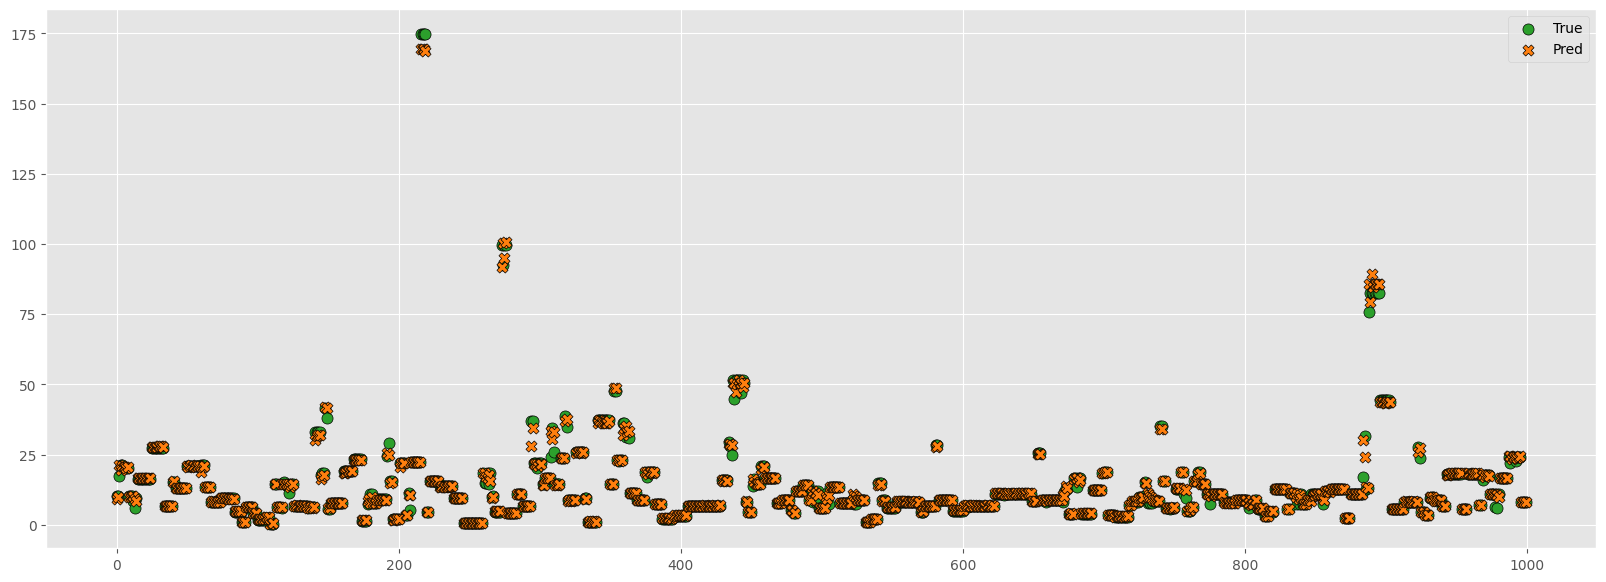

In [22]:
if y_pred.shape[1] > 1:
  serie_to_plot = -1
  n_points_plot = 1000
  y_true_points = np.vstack(y_test.reshape(y_test.shape[0], n_future, n_series)[::n_future,:,:])[:,serie_to_plot][:n_points_plot]
  y_pred_points = np.vstack(y_pred.reshape(y_pred.shape[0], n_future, n_series)[::n_future,:,:])[:,serie_to_plot][:n_points_plot]
  plt.figure(figsize=(20,7))
  plt.scatter(range(len(y_true_points)), y_true_points, label='True',edgecolors='k', c='#2ca02c', s=64)
  plt.scatter(range(len(y_true_points)), y_pred_points, label='Pred',edgecolors='k', marker='X', c='#ff7f0e', s=64)
  plt.legend()
  plt.show()

else:
  n_points_plot = 1000
  y_true_points = np.vstack(y_test.reshape(y_test.shape[0], n_future)[::n_future,:])[:n_points_plot]
  y_pred_points = np.vstack(y_pred.reshape(y_pred.shape[0], n_future)[::n_future,:])[:n_points_plot]
  plt.figure(figsize=(20,7))
  plt.scatter(range(len(y_true_points)), y_true_points, label='True',edgecolors='k', c='#2ca02c', s=64)
  plt.scatter(range(len(y_true_points)), y_pred_points, label='Pred',edgecolors='k', marker='X', c='#ff7f0e', s=64)
  plt.legend()
  plt.show()

Autoregressive to predict unlimited future data

In [23]:
def multi_step_forecast(model, x_test, n_futures):
    n_steps = n_future * (n_futures // n_future + 1)
    predictions = np.zeros((n_steps, x_test.shape[1]))
    for i in range(0, n_steps, n_future):
        y_p = model.predict(x_test[np.newaxis,:],verbose=0)
        if y_p.shape[1] > 1:
            y_p = y_p.reshape(n_future, n_series)
        x_test = np.roll(x_test, -n_future, axis=0)
        x_test[-n_future:,:] = y_p
        predictions[i:i+n_future,:] = y_p

    return predictions[:n_futures]

In [24]:
n_forecast = 100

In [25]:
forecasts = multi_step_forecast(model, X_train[-1], n_forecast)

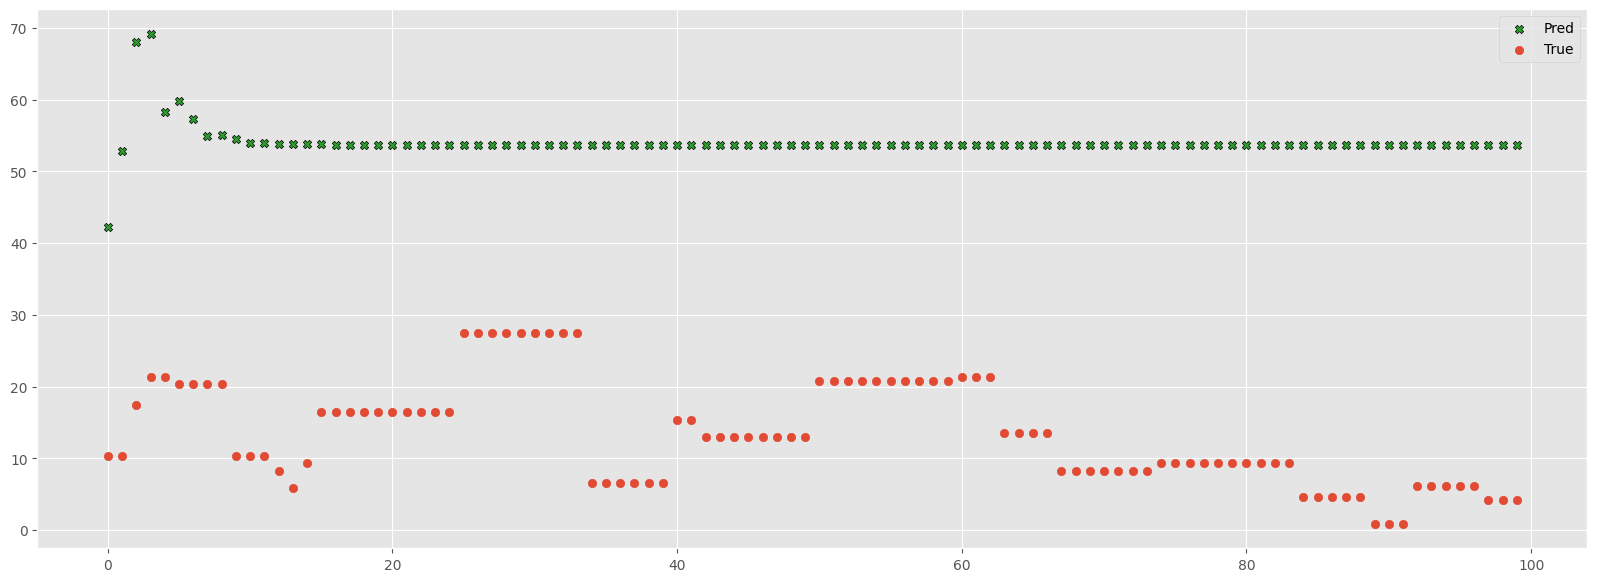

In [29]:
serie_to_plot = -1
forecast_points = forecasts[:,serie_to_plot]
true_points = y_test[:,serie_to_plot][:n_forecast]
plt.figure(figsize=(20,7))
plt.scatter(range(len(forecast_points)), forecast_points, label='Pred', c='#2ca02c', marker='X', edgecolor='k')
plt.scatter(range(len(forecast_points)), true_points, label='True')
plt.legend()
plt.show()